# HW3 - Regression

## Imports & Style edit

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso



In [129]:
# Required test style for matplotlib.
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

## Preliminary: Updated Data Loading

In [130]:
# We load the data from the csv file: data_HW3.csv.

# !rm *.csv

# from google.colab import files
# print("Please load the modified Traing set csv data")
# uploadedData = files.upload()
# data_file = list(uploadedData)[0]

data_file = "data_HW3.csv"

In [131]:
# Extracting the data
data_set = pd.read_csv(data_file)

# Splitting the data
training_set, test_set = train_test_split(data_set, test_size=0.2, train_size=0.8, random_state=95+70)

In [132]:
SPECIAL_BLOOD_TYPES = ['O+', 'B+']
NORMALIZATION_THRESHOLDS = {'min': 0, 'max': 100}
NORMALIZATION_RANGE = [-1, 1]
COLUMNS_TO_NORMALIZE = 'PCR'
STANDARD_NORMALIZE_COLUMNS = ['PCR_02', 'PCR_05', 'PCR_10']

def prepare_data(training_data: pd.DataFrame, new_data: pd.DataFrame):
    """
    Our preparation of the data for the model.
    """
    temp_training_data = training_data.copy()
    temp_new_data = new_data.copy()
    fill_na(temp_training_data, temp_new_data)
    replace_blood_type(temp_new_data)
    for col in temp_new_data.filter(like=COLUMNS_TO_NORMALIZE):
        temp_new_data[col] = normalize_series(temp_training_data[col], temp_new_data[col])
    return temp_new_data


def fill_na(train_data: pd.DataFrame, new_data: pd.DataFrame):
    """
    Fill missing values in the data (By median).
    """
    na_columns = train_data.columns[train_data.isna().any()].tolist()
    for col in na_columns:
        new_data.fillna({col:train_data[col].median()}, inplace=True)



def replace_blood_type(data: pd.DataFrame):
    """
    Replace the blood type categorical values with a boolean value (What we've called special property).
    """
    data['blood_group'] = data.blood_type.isin(SPECIAL_BLOOD_TYPES)
    data.drop(['blood_type'], axis=1, inplace=True)


def get_normalization_function(series: pd.Series, a: int = NORMALIZATION_RANGE[0], b: int = NORMALIZATION_RANGE[1]):
    """
    Return true if we choose min_max normalization, and false otherwise.
    """
    # if NORMALIZATION_THRESHOLDS['min'] <= len(series[series <= (desc['max'] + desc['min']) / 2])/len(series) * 100 <= NORMALIZATION_THRESHOLDS['max']:
    if series.name not in STANDARD_NORMALIZE_COLUMNS:
        return MinMaxScaler((a, b))
    return StandardScaler()


def normalize_series(train_data: pd.Series, new_data: pd.Series):
    """
    Normalize a series.
    """
    normalization_scaler = get_normalization_function(train_data)
    normalization_scaler.fit(train_data.values.reshape(-1, 1))
    return normalization_scaler.transform(new_data.values.reshape(-1, 1))

In [133]:
# Prepare training set according to itself
train_set_processed = prepare_data(training_set, training_set)

# Prepare test set according to the raw training set
test_set_processed = prepare_data(training_set, test_set)

## Section 1: Linear regression implementation

In [134]:
# Split the training set into 80% training and 20% validation
copy_train_set = train_set_processed.copy()
training_subset, validation_subset = train_test_split(copy_train_set, test_size=0.2, train_size=0.8, random_state=95+70)

In [135]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # loss calculation
        m = len(y)
        loss = 1/m * (np.linalg.norm(X.dot(w) + np.ones(m)*b - y , ord=2))**2
        
        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # calculate the analytical gradient w.r.t w and b
        m = len(y)
        g_w = 1/(m) * 2 * np.transpose(X).dot(X.dot(w) + np.ones(m) * b - y)
        g_b = 2/(m) * np.sum((X.dot(w) + np.ones(m) * b - y))

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w , self.b , batch_X , batch_y)

            # Perform a gradient step
            # Update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # Compute the regression prediction
        y_pred = np.dot(X, self.w) + self.b

        return y_pred

In [136]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


<>:53: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:53: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
C:\Users\eyal\AppData\Local\Temp\ipykernel_23484\3964310753.py:53: SyntaxWarning: invalid escape sequence '\d'
  axs[0].set_xlabel('$\delta_w$', fontsize=18)
C:\Users\eyal\AppData\Local\Temp\ipykernel_23484\3964310753.py:54: SyntaxWarning: invalid escape sequence '\d'
  axs[1].set_xlabel('$\delta_b$', fontsize=18)


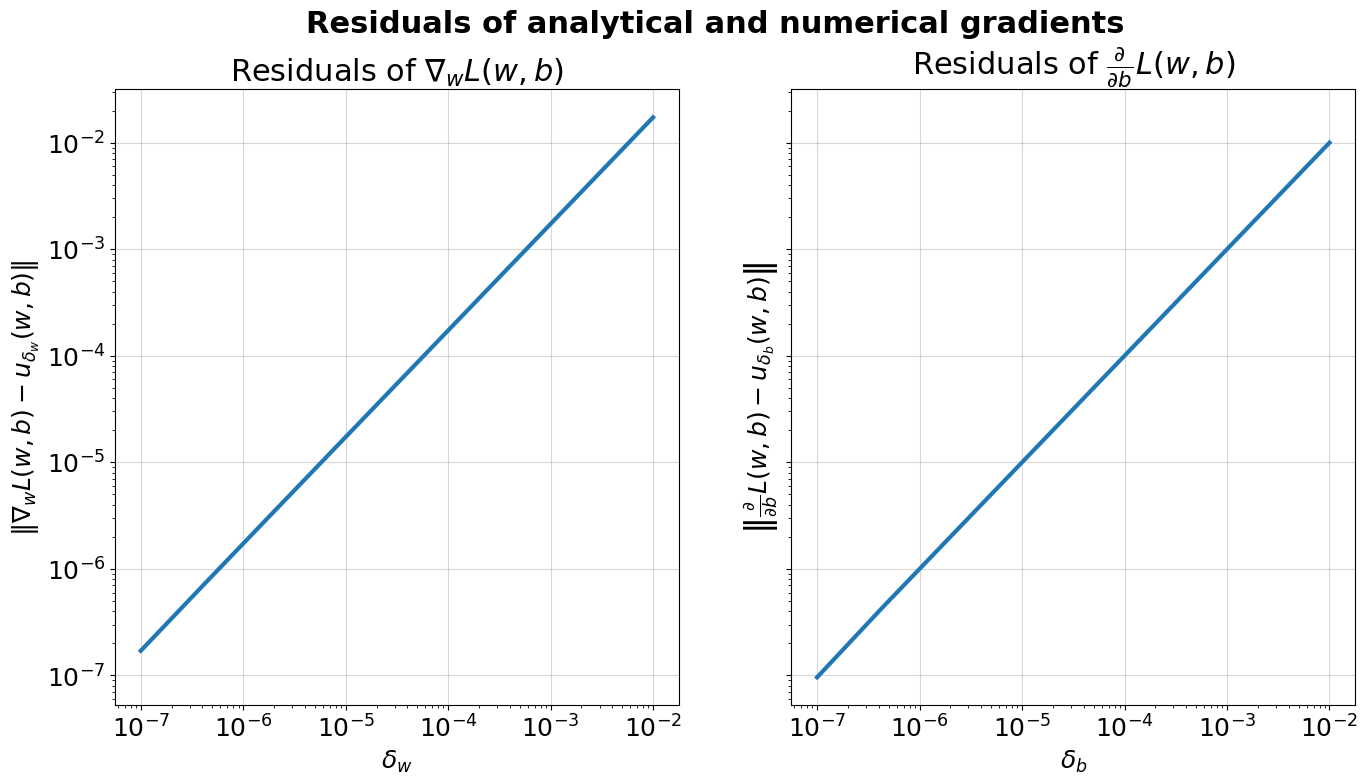

In [137]:
X_train = training_subset.filter(like="PCR")
y_train = training_subset["contamination_level"]
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

In [138]:
def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 5.7724317635483215, Best validation loss = 3.8943329551484056
lr size = 1e-08, Best train loss = 5.7723513866340195, Best validation loss = 3.8942734252971856
lr size = 1e-07, Best train loss = 5.771547852495173, Best validation loss = 3.893678330440564
lr size = 1e-06, Best train loss = 5.763535964629664, Best validation loss = 3.887747704181439
lr size = 1e-05, Best train loss = 5.6857162442494875, Best validation loss = 3.830431085835633
lr size = 0.0001, Best train loss = 5.097457785233401, Best validation loss = 3.4195287754963113
lr size = 0.001, Best train loss = 4.21024600077651, Best validation loss = 3.0541950975163163
lr size = 0.01, Best train loss = 4.165281966253087, Best validation loss = 3.052439303271723
lr size = 0.1, Best train loss = 4.179964281918928, Best validation loss = 3.0978523470685695


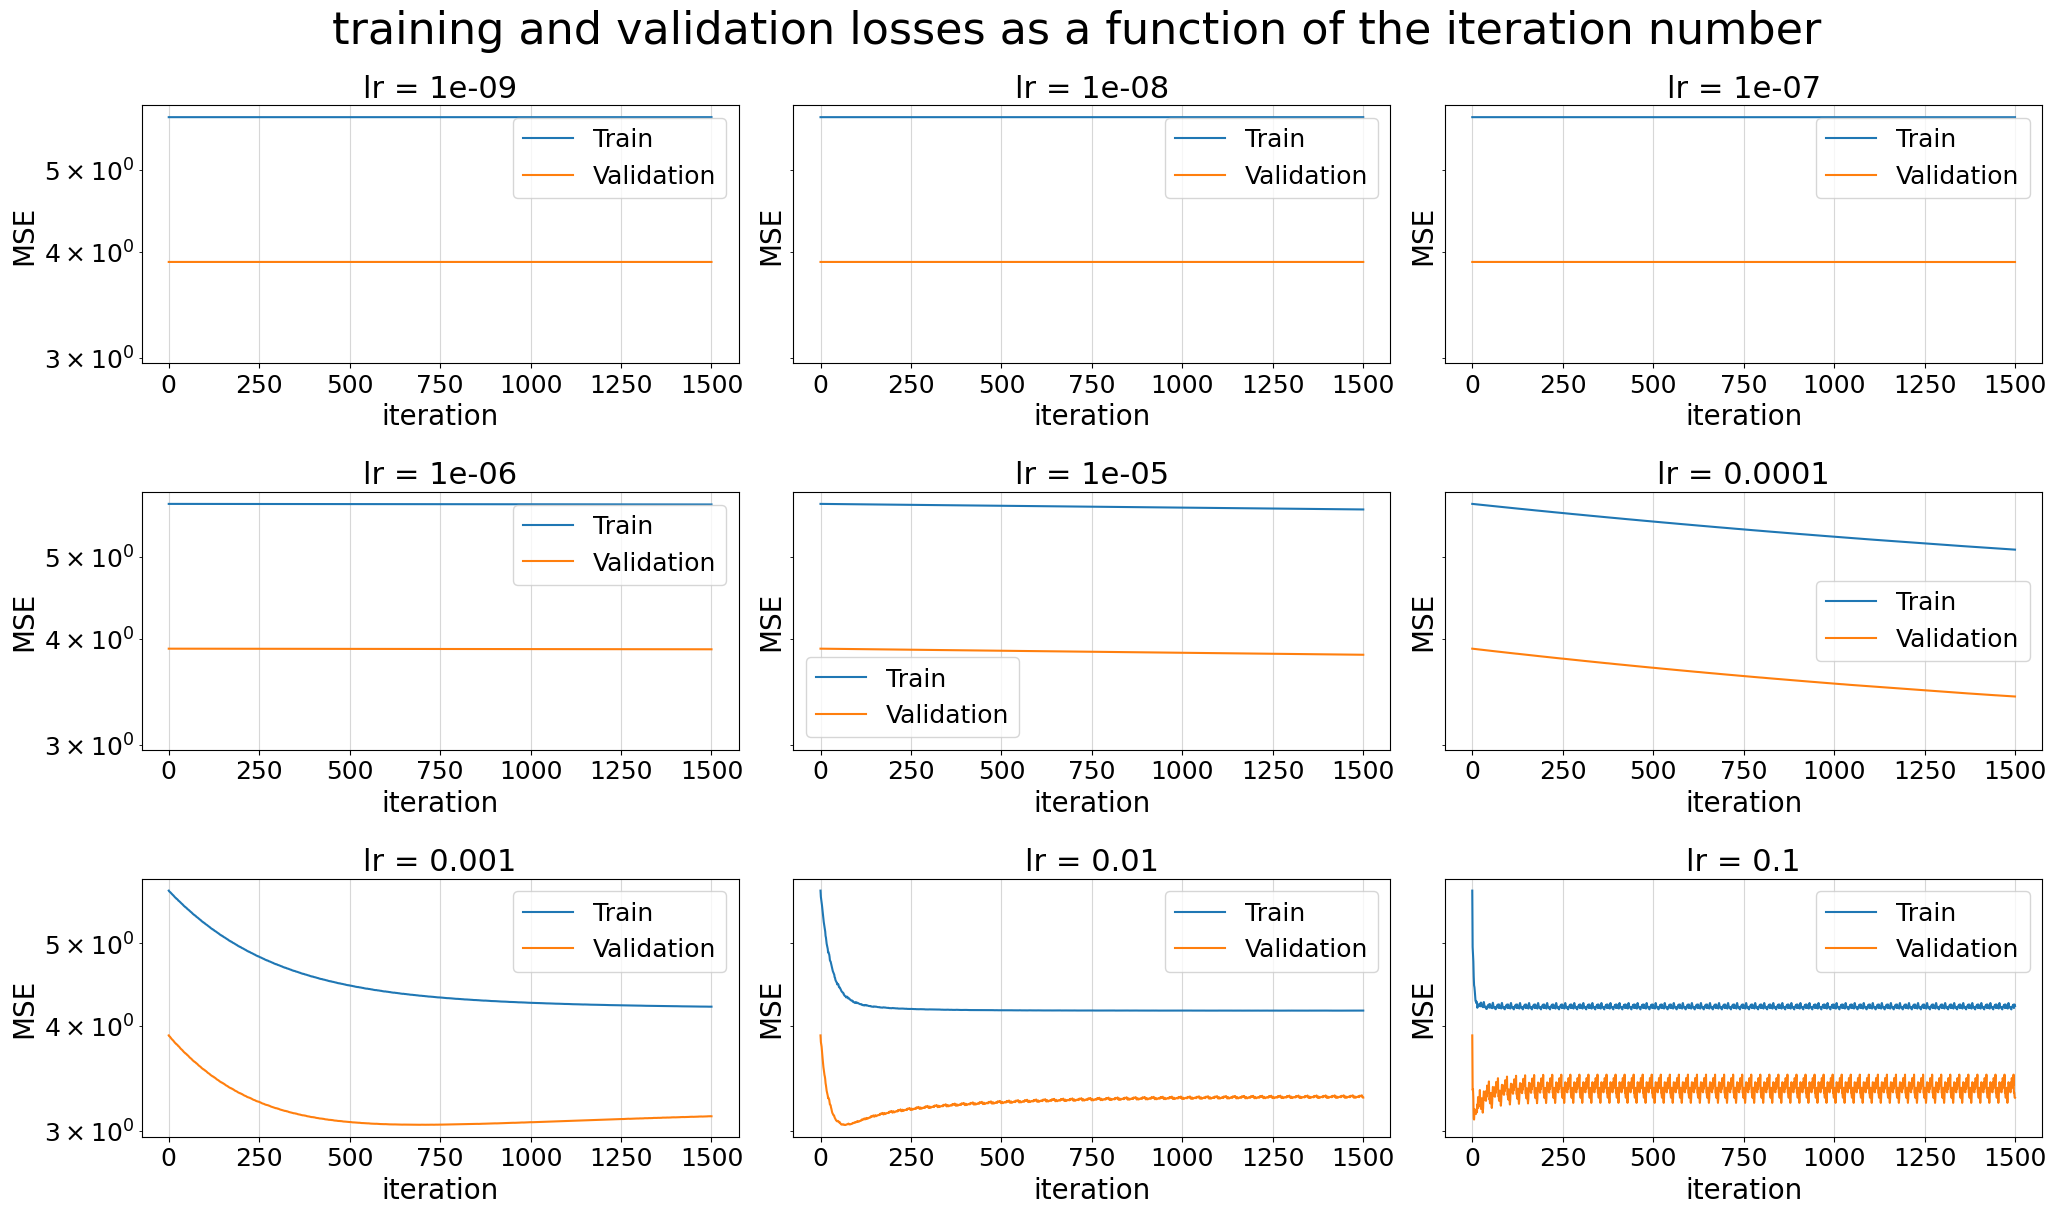

In [139]:
X_train = training_subset.filter(like="PCR")
y_train = training_subset["contamination_level"]
X_val = validation_subset.filter(like="PCR")
y_val = validation_subset["contamination_level"]
test_lr(X_train, y_train, X_val, y_val, "training and validation losses as a function of the iteration number")

## Section 2: Evaluation and Baseline

### Simplest baseline

In [140]:
# Q4

# Create training set with normalized features
dummy_X_train = train_set_processed.filter(like='PCR')
dummy_y_train = train_set_processed['contamination_level']

# Create dummy regressor (default is by mean)
dummy_regressor = DummyRegressor()

# Perform cross validation
dummy_results = cross_validate(dummy_regressor, dummy_X_train, dummy_y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Print results
print('Dummy Regressor Train Score: ', np.mean(-dummy_results['train_score']))
dummy_validation_score = np.mean(-dummy_results['test_score'])
print('Dummy Regressor Validation Score: ', dummy_validation_score)


Dummy Regressor Train Score:  4.07871423877061
Dummy Regressor Validation Score:  4.09503407912858


In [141]:
# Retrain the dummy regressor on the entire training set
# Task for section 6
dummy_regressor.fit(train_set_processed, train_set_processed['contamination_level'])

DummyRegressor()

### Basic hyperparameter tuning

In [142]:
# Q5
# Create logspace for learning rate, and lists to store the results
learning_rate_list = np.logspace(-9, -1, 20)
training_list = []
validation_list = []

for lr in learning_rate_list:
    # Create X and y for training of the model
    regressor_X_train = train_set_processed.filter(like='PCR')
    regressor_y_train = train_set_processed['contamination_level']
    
    # Create the linear regressor
    linear_regresseor = LinearRegressor(lr)
    linear_results = cross_validate(linear_regresseor, regressor_X_train, regressor_y_train, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)

    # Append the results to the lists
    training_list.append(np.mean(-linear_results['train_score']))
    validation_list.append(np.mean(-linear_results['test_score']))


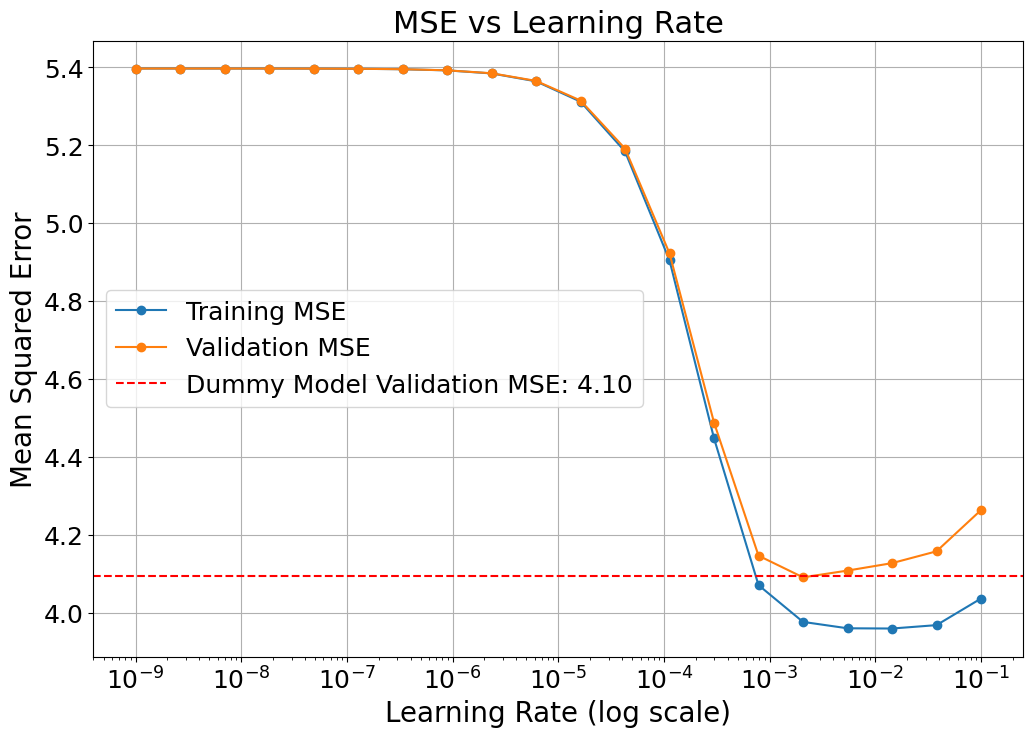

In [143]:
# Plot the results

results_df = pd.DataFrame({
    'Learning Rate': learning_rate_list,
    'Training MSE': training_list,
    'Validation MSE': validation_list
})

# Plotting with Matplotlib the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Learning Rate'], results_df['Training MSE'], marker='o', linestyle='-', label='Training MSE')
plt.plot(results_df['Learning Rate'], results_df['Validation MSE'], marker='o', linestyle='-', label='Validation MSE')
plt.axhline(y=dummy_validation_score, color='r', linestyle='--', label=f'Dummy Model Validation MSE: {dummy_validation_score:.2f}')

# Use a logarithmic scale for the learning rate
plt.xscale('log')  
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()


In [144]:
# Print the optimal results
optimal_lr = learning_rate_list[np.argmin(validation_list)]
optimal_lineaer_score = np.min(validation_list)

print('Optimal learning rate: ', optimal_lr)
print('Validation score: ', optimal_lineaer_score)
print('Training score: ', training_list[np.argmin(validation_list)])

Optimal learning rate:  0.00206913808111479
Validation score:  4.0913728947070895
Training score:  3.9770606857321886


In [145]:
# Retrain the model with the optimal learning rate
# Task for section 6
optimal_linear_regressor = LinearRegressor(optimal_lr)
optimal_linear_regressor.fit(train_set_processed.filter(like='PCR'), train_set_processed['contamination_level'])

LinearRegressor(lr=np.float64(0.00206913808111479))

## Section 3: Lasso linear regression

In [177]:
# Q7
# Create logspace for learning rate, and lists to store the results
alpha_list = np.logspace(-7, -1, 20)
lasso_training_list = []
lasso_validation_list = []

for alpha in alpha_list:
    # Create X and y for training of the model
    lasso_X_train = train_set_processed.filter(like='PCR')
    lasso_y_train = train_set_processed['contamination_level']
    
    # Create the linear regressor
    lasso_regresseor = Lasso(alpha)
    lasso_results = cross_validate(lasso_regresseor, lasso_X_train, lasso_y_train, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)

    # Append the results to the lists
    lasso_training_list.append(np.mean(-lasso_results['train_score']))
    lasso_validation_list.append(np.mean(-lasso_results['test_score']))

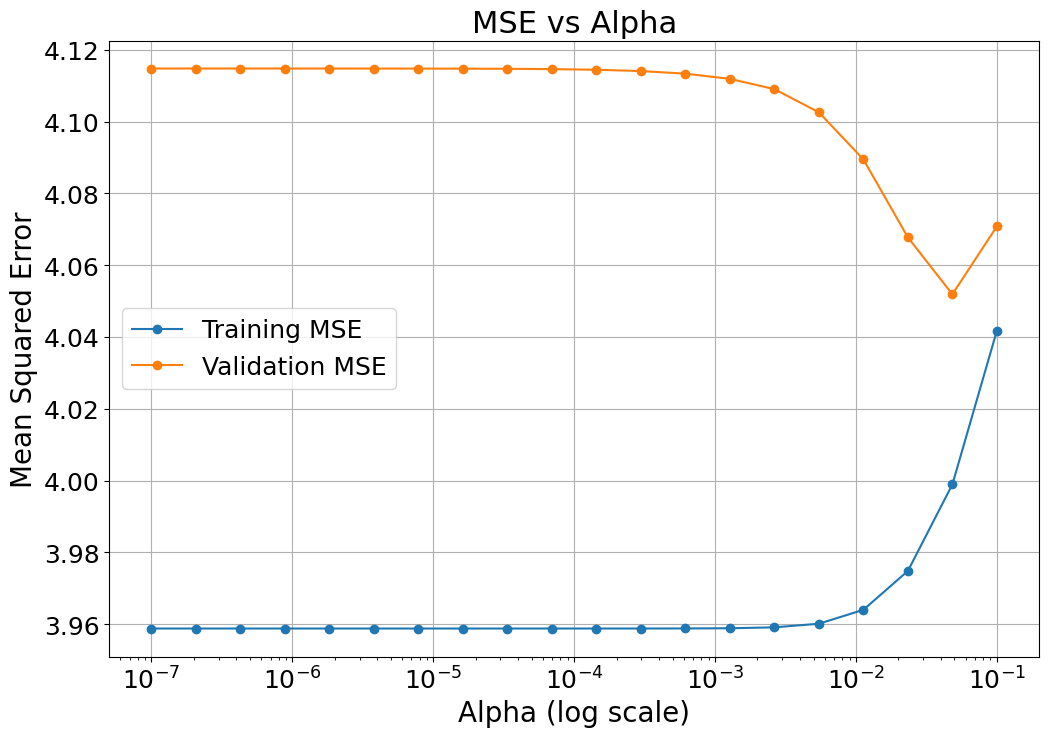

In [178]:
# Plot the results

results_df = pd.DataFrame({
    'Alpha': alpha_list,
    'Training MSE': lasso_training_list,
    'Validation MSE': lasso_validation_list
})

# Plotting with Matplotlib the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Alpha'], results_df['Training MSE'], marker='o', linestyle='-', label='Training MSE')
plt.plot(results_df['Alpha'], results_df['Validation MSE'], marker='o', linestyle='-', label='Validation MSE')

# Use a logarithmic scale for the learning rate
plt.xscale('log')  
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [179]:
# Print the optimal results
optimal_alpha = alpha_list[np.argmin(lasso_validation_list)]
optimal_lasso_score = np.min(lasso_validation_list)

print('Optimal alpha: ', optimal_alpha)
print('Lasso validation score: ', optimal_lasso_score)
print('Lasso training score: ', lasso_training_list[np.argmin(lasso_validation_list)])

Optimal alpha:  0.04832930238571752
Lasso validation score:  4.051905150577147
Lasso training score:  3.998947353285439


In [180]:
# Retrain the model with the optimal Alpha
# Task for section 6
optimal_lasso = Lasso(optimal_alpha, fit_intercept=True)
optimal_lasso.fit(train_set_processed.filter(like='PCR'), train_set_processed['contamination_level'])

Lasso(alpha=np.float64(0.04832930238571752))

In [181]:
# Q9
coefficients = optimal_lasso.coef_
largest_5_coefficients = pd.Series(coefficients, index = train_set_processed.filter(like='PCR').columns).apply(abs).sort_values(ascending=False).head(5)
print(largest_5_coefficients)

PCR_03    0.302149
PCR_06    0.120731
PCR_01    0.000000
PCR_02    0.000000
PCR_04    0.000000
dtype: float64


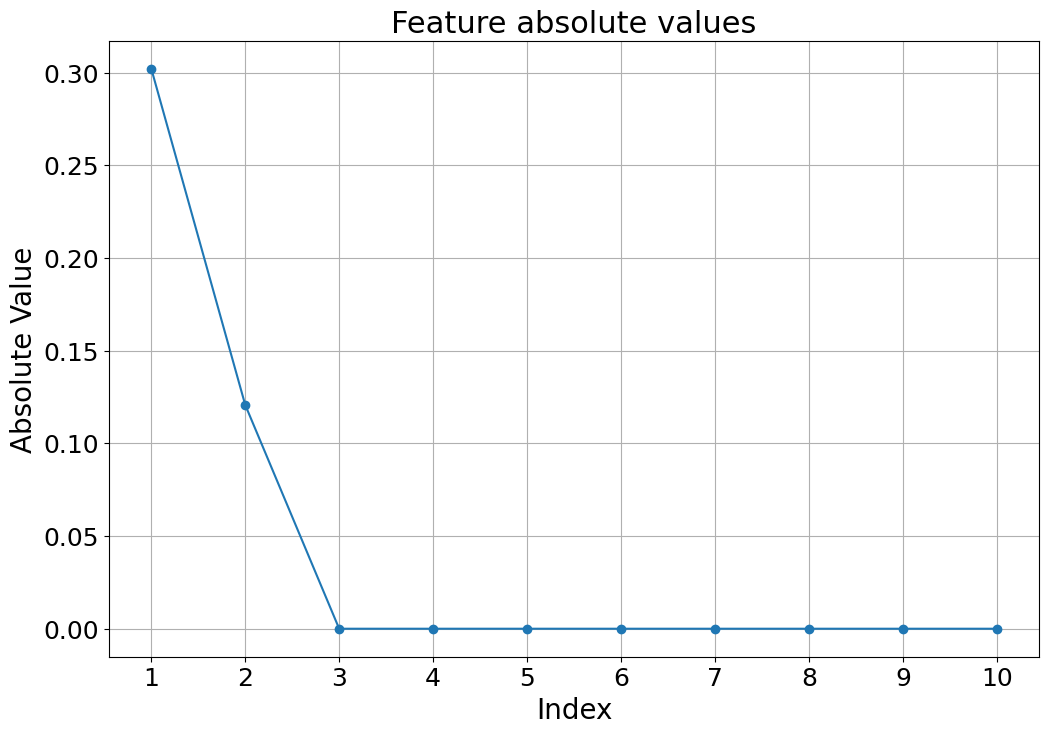

In [185]:
# Q10
sorted_coefficients = pd.Series(coefficients, index = train_set_processed.filter(like='PCR').columns).apply(abs).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), sorted_coefficients, marker='o')
plt.xlabel('Index')
plt.ylabel('Absolute Value')
plt.title('Feature absolute values')
plt.xticks(range(1, 11)) 
plt.grid(True)
plt.show()

## Section 4: Polynomial fitting (visualization)